In [1]:
import platform
import torch


def get_available_device(verbose=True):
    exec_device = torch.device('cpu')
    if torch.has_mps:
        exec_device = torch.device('mps')
    if torch.has_cuda:
        exec_device = torch.device('cuda')
    if verbose:
        print(f'Platform: {platform.system()}')
        print(f'Release: {platform.release()}')
        print(f'MPS available: {torch.has_mps}')
        print(f'CUDA available: {torch.has_cuda}')
        print(f'Selected device: {exec_device}')
    return exec_device


current_device = get_available_device()

Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


## Arch - backbone

In [2]:
import torchvision
from torchvision.models import resnet50, ResNet50_Weights


BACKBONES = {
    'resnet50': 'ResNet50_Weights'
}


def build_backbone(model_type):
    assert model_type in BACKBONES, f"{model_type} is not valid backbone type"
    model = getattr(torchvision.models, model_type)
    weights = getattr(torchvision.models, BACKBONES[model_type])
    return model(weights=weights.DEFAULT)


backbone = build_backbone('resnet50')

In [3]:
backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
random_input = torch.rand((1, 3, 512, 512), dtype=torch.float32)
random_input.shape

torch.Size([1, 3, 512, 512])

In [5]:
backbone(random_input).shape

torch.Size([1, 1000])

## Arch - FPN

In [6]:
from torch import nn
from typing import Dict
from collections import OrderedDict


class IntermediateLayerGetter(nn.ModuleDict):
    """
    Module wrapper that returns intermediate layers from a model
    It has a strong assumption that the modules have been registered
    into the model in the same order as they are used.
    This means that one should **not** reuse the same nn.Module
    twice in the forward if you want this to work.
    Additionally, it is only able to query submodules that are directly
    assigned to the model. So if `model` is passed, `model.feature1` can
    be returned, but not `model.feature1.layer2`.
    Args:
        model (nn.Module): model on which we will extract the features
        return_layers (Dict[name, new_name]): a dict containing the names
            of the modules for which the activations will be returned as
            the key of the dict, and the value of the dict is the name
            of the returned activation (which the user can specify).
    Examples::
        >>> m = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        >>> # extract layer1 and layer3, giving as names `feat1` and feat2`
        >>> new_m = torchvision.models._utils.IntermediateLayerGetter(m,
        >>>     {'layer1': 'feat1', 'layer3': 'feat2'})
        >>> out = new_m(torch.rand(1, 3, 224, 224))
        >>> print([(k, v.shape) for k, v in out.items()])
        >>>     [('feat1', torch.Size([1, 64, 56, 56])),
        >>>      ('feat2', torch.Size([1, 256, 14, 14]))]
    """

    _version = 2
    __annotations__ = {
        "return_layers": Dict[str, str],
    }

    def __init__(self, model: nn.Module, return_layers: Dict[str, str]) -> None:
        if not set(return_layers).issubset([name for name, _ in model.named_children()]):
            print([name for name, _ in model.named_children()])
            raise ValueError("return_layers are not present in model")
        orig_return_layers = return_layers
        return_layers = {str(k): str(v) for k, v in return_layers.items()}
        layers = OrderedDict()
        for name, module in model.named_children():
            layers[name] = module
            if name in return_layers:
                del return_layers[name]
            if not return_layers:
                break

        super().__init__(layers)
        self.return_layers = orig_return_layers

    def forward(self, x):
        out = OrderedDict()
        for name, module in self.items():
            x = module(x)
            if name in self.return_layers:
                out_name = self.return_layers[name]
                out[out_name] = x
        return out

In [7]:
import numpy as np


class Conv2dBN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=3, stride=1,
                 padding=1, bias=True, bias_value=None, bias_pi=None,
                 activation='LeakyReLU', activation_pars={'negative_slope': 0.01},
                 batch_norm=True):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(kernel, kernel),
            stride=(stride, stride),
            padding=(padding, padding),
            bias=bias,
        )
        if bias_pi:
            bias_value = -1. * np.log((1. - bias_pi) / bias_pi)
        if bias_value:
            self.conv.bias.data.fill_(bias_value)

        self.act = None
        if activation:
            self.act = getattr(torch.nn, activation)(**activation_pars)
        self.bn = None
        if batch_norm:
            self.bn = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        if self.act:
            x = self.act(x)
        return x

In [8]:
class FeatureExtractor(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self._backbone = backbone
        self._getter = IntermediateLayerGetter(
            model=self._backbone,
            return_layers = {
                'layer2': 'P3',
                'layer3': 'P4',
                'layer4': 'P5',
            }
        )
        self._fpn = torchvision.ops.FeaturePyramidNetwork(
            in_channels_list=[512, 1024, 2048],
            out_channels=256,
        )
        self._conv1 = Conv2dBN(in_channels=256, out_channels=256, kernel=3, stride=2, padding=1)
        self._conv2 = Conv2dBN(in_channels=256, out_channels=256, kernel=3, stride=2, padding=1)

    def forward(self, x):
        feature_maps = self._fpn(self._getter(x))
        feature_maps['P6'] = self._conv1(feature_maps['P5'])
        feature_maps['P7'] = self._conv1(feature_maps['P6'])
        return feature_maps


    @property
    def feature_maps(self):
        return ['P3', 'P4', 'P5', 'P6', 'P7']


fext = FeatureExtractor(backbone)

In [9]:
for k, v in fext(random_input).items():
    print(k, v.shape)

P3 torch.Size([1, 256, 64, 64])
P4 torch.Size([1, 256, 32, 32])
P5 torch.Size([1, 256, 16, 16])
P6 torch.Size([1, 256, 8, 8])
P7 torch.Size([1, 256, 4, 4])


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


## Arch - heads

In [10]:
class RegressionHead(nn.Module):
    def __init__(self, layers=4, channels=256):
        super().__init__()
        self.layers = [
            Conv2dBN(
                in_channels=channels,
                out_channels=channels
            )
            for _ in range(layers)
        ]
        self.layers.append(
            Conv2dBN(
                in_channels=channels,
                out_channels=4,
                activation='ReLU',
                activation_pars={},
            )
        )
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [11]:
regr_head = RegressionHead()
regr_head(torch.rand((1, 256, 240, 320), dtype=torch.float32)).shape

torch.Size([1, 4, 240, 320])

In [67]:
class ClassificationHead(nn.Module):
    def __init__(self, classes, layers=4, channels=256):
        super().__init__()
        self.neck = [
            Conv2dBN(
                in_channels=channels,
                out_channels=channels,
            )
            for _ in range(layers)
        ]
        self.logits_head = Conv2dBN(
            in_channels=channels,
            out_channels=classes,
            activation='Sigmoid',
            activation_pars={},
            bias_pi=0.01,
        )
        self.centerness_head = Conv2dBN(
            in_channels=channels,
            out_channels=1,
            activation='Sigmoid',
            activation_pars={},
            bias_pi=0.01,
        )        

    def forward(self, x):
        for layer in self.neck:
            x = layer(x)
        return self.logits_head(x), self.centerness_head(x)

In [68]:
clf_head = ClassificationHead(2)
[x.shape for x in clf_head(torch.rand((1, 256, 64, 64), dtype=torch.float32))]

[torch.Size([1, 2, 64, 64]), torch.Size([1, 1, 64, 64])]

## Arch - all together

In [69]:
class FcosCore(nn.Module):
    def __init__(self, backbone, classes):
        super().__init__()
        self._fext = FeatureExtractor(backbone)
        self._regression_heads = {name: RegressionHead(channels=256) for name in self._fext.feature_maps}
        self._clf_heads = {name: ClassificationHead(classes, channels=256) for name in self._fext.feature_maps}

    def forward(self, x):
        out = {}
        for k, fmap in self._fext(x).items():
            out[k] = (
                self._clf_heads[k](fmap),
                self._regression_heads[k](fmap),
            )
        return out

In [70]:
model = FcosCore(backbone, 3)

In [71]:
model

FcosCore(
  (_fext): FeatureExtractor(
    (_backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [17]:
rand_input = torch.rand((4, 3, 256, 256), dtype=torch.float32)
rand_input.shape

torch.Size([4, 3, 256, 256])

In [18]:
out = model(rand_input)

In [19]:
for k, ((cls, cntr), r) in out.items():
    print(k, cls.shape, cntr.shape, r.shape)

P3 torch.Size([4, 3, 32, 32]) torch.Size([4, 1, 32, 32]) torch.Size([4, 4, 32, 32])
P4 torch.Size([4, 3, 16, 16]) torch.Size([4, 1, 16, 16]) torch.Size([4, 4, 16, 16])
P5 torch.Size([4, 3, 8, 8]) torch.Size([4, 1, 8, 8]) torch.Size([4, 4, 8, 8])
P6 torch.Size([4, 3, 4, 4]) torch.Size([4, 1, 4, 4]) torch.Size([4, 4, 4, 4])
P7 torch.Size([4, 3, 2, 2]) torch.Size([4, 1, 2, 2]) torch.Size([4, 4, 2, 2])


## Preprocessing & postprocessing

In [20]:
class FcosPreprocessing(nn.Module):
    def __init__(self):
        super().__init__()

In [21]:
# TODO

## Explore dataset

In [22]:
dataset = torchvision.datasets.VOCDetection(
    root="vocdata",
    year="2012",
    image_set="train",
    download=True,
    transforms=None,
)

Using downloaded and verified file: vocdata/VOCtrainval_11-May-2012.tar
Extracting vocdata/VOCtrainval_11-May-2012.tar to vocdata


In [23]:
# https://www.w3schools.com/tags/ref_colornames.asp

COLOR_MAP = {
    "person": "red",
    "bottle": "aqua",
    "chair": "brown",
    "diningtable": "SandyBrown",
    "pottedplant": "green",
    "tv/monitor": "blue",
    "sofa": "purple",
    "aeroplane": "LightSlateGray",
    "bicycle": "SkyBlue",
    "boat": "orange",
    "bus": "lime",
    "car": "Olive",
    "motorbike": "pink",
    "train": "DarkGrey",
    "bird": "black",
    "cat": "salmon",
    "cow": "GreenYellow",
    "dog": "yellow",
    "horse": "Turquoise",
    "sheep": "white",    
}


In [24]:
sample = dataset[700]

img = torch.from_numpy(np.array(sample[0]))
img = torch.permute(img, (2, 0, 1))
img.shape

boxes = []
labels = []
colors = []
for obj in sample[1]['annotation']['object']:
    box = obj['bndbox']
    boxes.append(
        [int(x) for x in [box['xmin'], box['ymin'], box['xmax'], box['ymax']]]
    )
    labels.append(
        obj['name']
    )
    colors.append(
        COLOR_MAP[labels[-1]]
    )

boxes = torch.from_numpy(np.array(boxes))

vis = torchvision.utils.draw_bounding_boxes(
    image=img,
    boxes=boxes,
    labels=labels,
    width=3,
    colors=colors,
)
vis = np.transpose(vis.numpy(), [1, 2, 0])

### Transforms

In [25]:
import albumentations as A
from albumentations.augmentations.geometric.transforms import HorizontalFlip
from albumentations.augmentations.crops.transforms import RandomResizedCrop 
from albumentations.augmentations.geometric.rotate import Rotate
from matplotlib.pyplot import imshow

In [26]:
def preprocess_voc_sample(sample):
    image, annotation = sample
    image = np.array(image)
    annotation = annotation['annotation']
#     width = int(annotation['size']['width'])
#     height = int(annotation['size']['height'])
    boxes = []
    for obj in annotation['object']:
        boxes.append([
            float(obj['bndbox']['xmin']),# / width,
            float(obj['bndbox']['ymin']),# / height,
            float(obj['bndbox']['xmax']),# / width,
            float(obj['bndbox']['ymax']),# / height,
            obj['name']
        ])
    return {
        'image': image,
        'bboxes': boxes,
    }

def visualize(sample):
    ysz, xsz = sample['image'].shape[:2]
    boxes, labels = [], []
    for obj in sample['bboxes']:
        boxes.append(obj[:-1])
        labels.append(obj[-1])
    
    vis = sample['image']
    if boxes:
        boxes = torch.from_numpy(np.array(boxes))
        boxes[:, 0] = boxes[:, 0]# * xsz
        boxes[:, 1] = boxes[:, 1]# * ysz
        boxes[:, 2] = boxes[:, 2]# * xsz
        boxes[:, 3] = boxes[:, 3]# * ysz

        vis = torchvision.utils.draw_bounding_boxes(
            image=torch.from_numpy(
                np.transpose(sample['image'], [2, 0, 1])
            ),
            boxes=boxes if len(boxes) else None,
            labels=labels if len(labels) else None,
            width=3,
            colors=[COLOR_MAP[x] for x in labels],
        )
        vis = np.transpose(vis.numpy(), [1, 2, 0])
    imshow(vis)

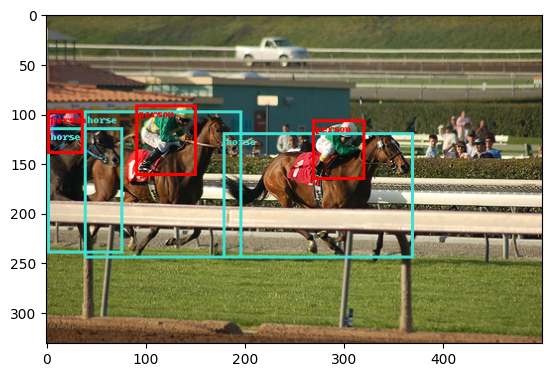

In [27]:
sample = preprocess_voc_sample(dataset[900])
visualize(sample)

In [28]:
sample = preprocess_voc_sample(dataset[900])

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45),
    A.SmallestMaxSize(256, interpolation=1),
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3))

transformed = transform(image=sample['image'], bboxes=sample['bboxes'])
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_bboxes

[(62.14882202290326,
  55.21577861139058,
  229.34288879036762,
  211.69149262442733,
  'horse'),
 (0.0, 116.38494798782976, 127.37625465866043, 256.0, 'horse'),
 (0.0, 177.81422444751084, 54.50395412380263, 256.0, 'horse'),
 (109.62064942386996,
  68.55463178887354,
  166.5869752602107,
  126.60118762139233,
  'person'),
 (0.0, 132.56106897250274, 64.67334913436875, 200.51394432087406, 'person')]

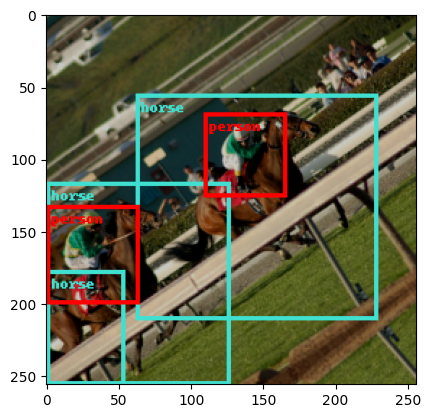

In [29]:
visualize(transformed)

## Dataloader

In [30]:
class VocPreprocessor:
    def __init__(self):
        self._pipeline = A.Compose(
            [
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45),
                A.SmallestMaxSize(256, interpolation=1),
                A.RandomCrop(width=256, height=256),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
            ],
            bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.3)
        )

    def __call__(self, image, bboxes):
        preprocessed = VocPreprocessor.preprocess_sample((image, bboxes))
        r = self._pipeline(image=preprocessed['image'], bboxes=preprocessed['bboxes'])
        return r['image'], r['bboxes']
    
    @staticmethod
    def preprocess_sample(sample):
        image, annotation = sample
        image = np.array(image)
        annotation = annotation['annotation']
        boxes = []
        for obj in annotation['object']:
            boxes.append([
                float(obj['bndbox']['xmin']),
                float(obj['bndbox']['ymin']),
                float(obj['bndbox']['xmax']),
                float(obj['bndbox']['ymax']),
                obj['name']
            ])
        return {
            'image': image,
            'bboxes': boxes,
        }

train_dataset = torchvision.datasets.VOCDetection(
    root="vocdata",
    year="2012",
    image_set="train",
    download=False,
    transforms=VocPreprocessor(),
)

from torch.utils.data import DataLoader

class LabelsCodec:
    def __init__(self):
        self._names = [
            'person', 'bottle', 'chair', 'diningtable',
            'pottedplant', 'tvmonitor', 'sofa', 'aeroplane',
            'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
            'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
        ]
        self._name2id = dict(zip(self._names, list(range(len(self._names)))))
        self._id2name = {v: k for k, v in self._name2id.items()}
        self._colors = [
            'red', 'aqua', 'brown', 'SandyBrown', 'green', 'blue',
            'purple', 'LightSlateGray', 'SkyBlue', 'orange', 'lime',
            'Olive', 'pink', 'DarkGrey', 'black', 'salmon', 'GreenYellow',
            'yellow', 'Turquoise', 'white'
        ]

    def encode(self, name):
        return self._name2id[name]

    def decode(self, class_idx):
        return self._id2name[class_idx]

    def color(self, idx):
        if isinstance(idx, str):
            idx = self.encode(idx)
        return self._colors[idx]

    def __len__(self):
        return len(self._names)


def collate(batch):
    codec = LabelsCodec()
    images, bboxes, labels = [], [], []
    for image, img_targets in batch:
        images.append(image)
        img_boxes, img_labels = [], []
        for obj in img_targets:
            img_boxes.append(obj[:-1])
            img_labels.append(codec.encode(obj[-1]))
        bboxes.append(torch.FloatTensor(img_boxes))
        labels.append(torch.IntTensor(img_labels))
    return torch.Tensor(images), bboxes, labels

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate)

img, boxes, labels = next(iter(train_dataloader))

/var/folders/3q/2zcvm1657mzdfv8n07vmkwr40000gn/T/ipykernel_1055/271485481.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.Tensor(images), bboxes, labels


In [31]:
img.shape

torch.Size([4, 256, 256, 3])

In [32]:
boxes

[tensor([[ 93.3200, 127.6587, 256.0000, 223.9147],
         [139.6960, 197.2907, 256.0000, 256.0000],
         [ 36.7140, 103.0827, 229.0380, 178.8587],
         [  9.4340, 105.8133, 119.9180, 154.2827],
         [  0.0000, 100.3520,  77.6340, 134.4853],
         [  0.0000,  86.6987, 102.8680, 116.7360],
         [  0.0000,  82.6027,  72.8600, 105.8133],
         [  0.0000,  83.2853,  39.4420, 105.8133],
         [  0.0000,  77.1413,  38.0780, 105.8133]]),
 tensor([[  0.0000,  59.3920, 256.0000, 157.6960]]),
 tensor([[ 10.6470,   0.0000, 256.0000, 256.0000],
         [ 13.3679,   0.0000, 256.0000, 256.0000]]),
 tensor([[  6.3200,  59.7560,  74.3200, 112.7215],
         [ 76.3600,  64.5093, 121.2400,  89.6339],
         [152.5200,  63.8302, 214.4000, 120.1910],
         [  9.7200,  61.7931, 194.0000, 256.0000]])]

In [33]:
labels

[tensor([16, 16, 16, 16, 16, 16, 16, 16, 16], dtype=torch.int32),
 tensor([10], dtype=torch.int32),
 tensor([ 0, 11], dtype=torch.int32),
 tensor([5, 5, 5, 0], dtype=torch.int32)]

## Preprocessing & posprocessing

In [34]:
class FcosPreprocessor(nn.Module):
    def __init__(self, target_resolution=(512, 512)):
        super().__init__()
        self._height, self._width = target_resolution
        self._normalize = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def _prepare_single_image(self, tensor_or_array):
        assert len(tensor_or_array.shape) == 3
        if isinstance(tensor_or_array, np.ndarray):
            tensor = torch.from_numpy(tensor_or_array)
        else:
            tensor = tensor_or_array
        if tensor.shape[0] != 3 and tensor.shape[-1] == 3:
            tensor = torch.permute(tensor, (2, 0, 1))
        _, h, w = tensor.shape
        scale = (1., 1.)
        if (h, w) != (self._height, self._width):
            scale = (h / self._height, w / self._width)
            tensor = torchvision.transforms.Resize(
                size=(self._height, self._width),
                interpolation=torchvision.transforms.InterpolationMode.BILINEAR
            )(tensor)
        return tensor.float(), scale

    def forward(self, img_or_batch):
        if isinstance(img_or_batch, list) or len(img_or_batch.shape) == 4:
            tensors_and_scales = [self._prepare_single_image(x) for x in img_or_batch]
            tensors, scales = zip(*tensors_and_scales)
            tensors = torch.stack(tensors)
        else:
            tensor, scale = self._prepare_single_image(img_or_batch)
            tensors, scales = torch.unsqueeze(tensor, 0), [scale]
        b, c, h, w = tensors.shape
        assert c == 3 and h == self._height and w == self._width and b > 0, \
            f"b, h, w, c = {b, h, w, c}"
        normalized_tensors = self._normalize(tensors)
        return normalized_tensors, scales

In [35]:
class FcosPostprocessor(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, raw_predictions):
        flat_outputs = []

        for _, ((cls_map, cntr_map), regr_map) in out.items():
            b, c, h, w = cls_map.shape           
            flat_cls_map = torch.permute(
                torch.reshape(
                    cls_map,
                    (b, c, h * w)
                ),
                [0, 2, 1]
            )
            b, c, h, w = cntr_map.shape  
            flat_center_map = torch.permute(
                torch.reshape(
                    cntr_map,
                    (b, c, h * w)
                ),
                [0, 2, 1]
            )
            b, c, h, w = regr_map.shape 
            flat_regr_map = torch.permute(
                torch.reshape(
                    regr_map,
                    (b, c, h * w)
                ),
                [0, 2, 1]
            )

            flat_outputs.append(
                torch.cat(
                    [flat_cls_map, flat_center_map, flat_regr_map],
                    axis=2,
                )
            )

        return torch.cat(flat_outputs, axis=1)

    
pospr = FcosPostprocessor()
raw_outs = model(rand_input)
y = pospr(raw_outs)
y.shape
        
        

torch.Size([4, 1364, 8])

1. We have all positions -> convert to decoded boxes for each positions
    - probably we need only the boxes with high enough confidences (slice of indices-boxes)
    - for this purpose we need to encode linear position to coordinate on the image
2. ...

## Detections codec

In [36]:
import torch.nn.functional as F


def box_centerness(ltrb_box):
    l, t, r, b = ltrb_box
    return torch.sqrt(
        (min(l, r) * min(t, b)) / (max(l, r) * max(t, b))
    )


class FeatureMapCodec(nn.Module):
    def __init__(self, img_size, map_size, classes):
        super().__init__()
        self._img_width, self._img_height = img_size
        self._map_width, self._map_height = map_size
        self._stride_x = self._img_width / self._map_width
        self._stride_y = self._img_height / self._map_height
        self._classes = classes

    def _get_centers(self, indices):
        assert len(indices.shape) == 1, indices.shape
        n = indices.shape[0]
        centers = torch.zeros(n, 2).float()
        centers[:, 1] = indices[:] // self._map_width
        centers[:, 0] = indices[:] - centers[:, 1] * self._map_width
        centers[:, 0] = (centers[:, 0] + 0.5) * self._stride_x
        centers[:, 1] = (centers[:, 1] + 0.5) * self._stride_y
        return centers

    def decode(self, encoded_boxes):
        """
        encoded_boxes: [N x {batch_idx, plane_idx, l, t, r, b}]
        return: [N x {batch_idx, xmin, ymin, xmax, ymax}]
        """
        batch_idx, plane_idx, ltrb = \
            encoded_boxes[..., 0], encoded_boxes[..., 1], encoded_boxes[..., 2:]       
        centers = self._get_centers(plane_idx)

        xmin = centers[..., 0] - ltrb[..., 0]
        xmax = centers[..., 0] + ltrb[..., 2]
        ymin = centers[..., 1] - ltrb[..., 1]
        ymax = centers[..., 1] + ltrb[..., 3]
        
        return torch.cat(
            [
                batch_idx[..., None],
                xmin[..., None],
                ymin[..., None],
                xmax[..., None],
                ymax[..., None],
            ],
            axis=1,
        )

    def _encode_signle_position(self, map_pos, bbox):
        """
        map_pos: (map_x_idx, map_y_idx)
        bbox: (xmin, ymin, xmax, ymax)
        return: (plane_idx, l, t, r, b, centerness)
        """
        x_idx, y_idx = map_pos
        xmin, ymin, xmax, ymax = bbox
        
        plance_idx = y_idx * self._map_width + x_idx
        l = (x_idx + 0.5) * self._stride_x - xmin
        t = (y_idx + 0.5) * self._stride_y - ymin
        r = xmax - (x_idx + 0.5) * self._stride_x
        b = ymax - (y_idx + 0.5) * self._stride_y
        
        centerness = box_centerness((l, t, r, b))
        return plance_idx, l, t, r, b, centerness

    def _encode_object(self, bbox):
        """
        bbox: (xmin, ymin, xmax, ymax)
        return: [N x {plane_idx, l, t, r, b, centerness}]
        """
        res = []
        xmin, ymin, xmax, ymax = bbox
        
        xmin_norm = xmin / self._stride_x
        xmax_norm = xmax / self._stride_x
        ymin_norm = ymin / self._stride_y
        ymax_norm = ymax / self._stride_y

        x_idx_first, x_idx_last = int(xmin_norm + 0.5), int(xmax_norm - 0.5)
        y_idx_first, y_idx_last = int(ymin_norm + 0.5), int(ymax_norm - 0.5)

        def validate(v, l, h):
            return min(h, max(l, v))
        
        x_idx_first = validate(x_idx_first, 0, self._map_width - 1)
        x_idx_last = validate(x_idx_last, 0, self._map_width - 1)
        y_idx_first = validate(y_idx_first, 0, self._map_height - 1)
        y_idx_last = validate(y_idx_last, 0, self._map_height - 1)       
        
        for map_x in range(x_idx_first, x_idx_last + 1):
            for map_y in range(y_idx_first, y_idx_last + 1):
                plane_idx, l, t, r, b, centerness = \
                    self._encode_signle_position((map_x, map_y), bbox)
                res.append([plane_idx, l, t, r, b, centerness])

        return torch.Tensor(res)

    def encode(self, boxes):
        """
        boxes: [N x {batch_idx, class_idx, xmin, ymin, xmax, ymax}]
        return: [N x {batch_idx, plane_idx, l, t, r, b, centerness, logits_vector}]
        """
        all_encoded = []
        total_batches = (torch.max(boxes[:, 0]) + 1).int()
        coords_vector_size = 4
        centerless_vector_size = 1
        regression_vector_size = coords_vector_size + centerless_vector_size

        for batch_idx in range(total_batches):
            target_coords = torch.zeros(self._map_height * self._map_width, regression_vector_size)
            target_classes = torch.zeros(self._map_height * self._map_width, self._classes)
            
            image_objects = boxes[boxes[:, 0] == batch_idx][:, 1:]
            if len(image_objects) == 0:
                continue

            xsize = image_objects[:, 3] - image_objects[:, 1]
            ysize = image_objects[:, 4] - image_objects[:, 2]
            areas = torch.mul(xsize, ysize)
            _, indices = torch.sort(areas, descending=True)
            image_objects = image_objects[indices]
            
            for (class_idx, xmin, ymin, xmax, ymax) in image_objects:
                all_encoded_positions = self._encode_object((xmin, ymin, xmax, ymax))

                for encoded_pos in all_encoded_positions:
                    plane_index = encoded_pos[0].int()
                    class_id = class_idx.int()
                    target_coords[plane_index] = encoded_pos[1:]
                    target_classes[plane_index][class_id] = 1

            image_indices = torch.sum(target_classes, dim=1) > 0
            coords = target_coords[image_indices]
            classes = target_classes[image_indices]
            batch_col = torch.zeros(len(classes), 1) + batch_idx
            all_encoded.append(
                torch.hstack(
                    [batch_col, coords, classes]
                )
            )
                
        return torch.vstack(all_encoded)

In [45]:
boxes = [
    [0, 0, 1, 1, 8.5, 8.5],
    [0, 1, 3, 5, 7, 7],
    [2, 2, 1.1, 1.2, 5.7, 6.6],
]
boxes = torch.Tensor(np.asarray(boxes, dtype=np.float32))
codec.encode(boxes)   

tensor([[0.0000, 2.0000, 2.0000, 5.5000, 5.5000, 0.3636, 1.0000, 0.0000, 0.0000],
        [0.0000, 4.0000, 2.0000, 3.5000, 5.5000, 0.5641, 1.0000, 0.0000, 0.0000],
        [0.0000, 6.0000, 2.0000, 1.5000, 5.5000, 0.3015, 1.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 4.0000, 5.5000, 3.5000, 0.5641, 1.0000, 0.0000, 0.0000],
        [0.0000, 4.0000, 4.0000, 3.5000, 3.5000, 0.8750, 1.0000, 0.0000, 0.0000],
        [0.0000, 6.0000, 4.0000, 1.5000, 3.5000, 0.4677, 1.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 6.0000, 5.5000, 1.5000, 0.3015, 1.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 2.0000, 2.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000],
        [0.0000, 4.0000, 2.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000],
        [2.0000, 1.9000, 1.8000, 2.7000, 3.6000, 0.5932, 0.0000, 0.0000, 1.0000],
        [2.0000, 3.9000, 1.8000, 0.7000, 3.6000, 0.2996, 0.0000, 0.0000, 1.0000],
        [2.0000, 1.9000, 3.8000, 2.7000, 1.6000, 0.5443, 0.0000, 0.0000, 1.0000],
        [2.0000,

In [46]:
codec = FeatureMapCodec([10, 10], [5, 5], 3)
encoded_boxes = [
    [0, 0, 1, 1, 2, 2],
    [0, 1, 2, 1, 0, 4],
    [1, 24, 1, 1, 1, 1],
]
encoded_boxes = torch.Tensor(np.asarray(encoded_boxes, dtype=np.float32))

codec.decode(encoded_boxes)        

tensor([[ 0.,  0.,  0.,  3.,  3.],
        [ 0.,  1.,  0.,  3.,  5.],
        [ 1.,  8.,  8., 10., 10.]])

### Lets check if raw boxes may be converted back by codec

In [47]:
raw_boxes = [
    [0, 0, 1, 1, 9, 9,],
    [0, 1, 5, 4, 7, 6,],
    [1, 2, -1, -2, 10, 12],
    [3, 3, 1, 2, 3, 4],
    [3, 3, 4, 5, 6, 7],
]
raw_boxes = torch.Tensor(np.asarray(raw_boxes, dtype=np.float32))
raw_boxes

tensor([[ 0.,  0.,  1.,  1.,  9.,  9.],
        [ 0.,  1.,  5.,  4.,  7.,  6.],
        [ 1.,  2., -1., -2., 10., 12.],
        [ 3.,  3.,  1.,  2.,  3.,  4.],
        [ 3.,  3.,  4.,  5.,  6.,  7.]])

In [48]:
codec = FeatureMapCodec([10, 10], [5, 5], 4)

In [49]:
encoded = codec.encode(raw_boxes)
encoded

tensor([[ 0.0000,  2.0000,  2.0000,  6.0000,  6.0000,  0.3333,  1.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  4.0000,  2.0000,  4.0000,  6.0000,  0.5774,  1.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  6.0000,  2.0000,  2.0000,  6.0000,  0.3333,  1.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  8.0000,  2.0000,  0.0000,  6.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  2.0000,  4.0000,  6.0000,  4.0000,  0.5774,  1.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  4.0000,  4.0000,  4.0000,  4.0000,  1.0000,  1.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  2.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          0.0000,  0.0000],
        [ 0.0000,  8.0000,  4.0000,  0.0000,  4.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  2.0000,  6.0000,  6.0000,  2.0000,  0.3333,  1.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  

In [50]:
back = codec.decode(encoded)
back

tensor([[  0.0000,   3.0000,  -5.0000,  11.0000,   1.3333],
        [  0.0000,   7.0000,  -3.0000,  15.0000,   1.5774],
        [  0.0000,   1.0000,   1.0000,   9.0000,   3.3333],
        [  0.0000,   5.0000,   3.0000,  13.0000,   3.0000],
        [  0.0000,   1.0000,  -5.0000,   9.0000,   1.5774],
        [  0.0000,   5.0000,  -3.0000,  13.0000,   2.0000],
        [  0.0000,   4.0000,   1.0000,   6.0000,   1.0000],
        [  0.0000,   3.0000,   3.0000,  11.0000,   3.0000],
        [  0.0000,  -1.0000,  -5.0000,   7.0000,   1.3333],
        [  0.0000,   3.0000,  -3.0000,  11.0000,   1.5774],
        [  0.0000,  -3.0000,   1.0000,   5.0000,   3.3333],
        [  0.0000,   1.0000,   3.0000,   9.0000,   3.0000],
        [  0.0000,  -3.0000,  -5.0000,   5.0000,   1.0000],
        [  0.0000,   1.0000,  -3.0000,   9.0000,   1.0000],
        [  0.0000,  -5.0000,   1.0000,   3.0000,   3.0000],
        [  0.0000,  -1.0000,   3.0000,   7.0000,   3.0000],
        [  1.0000,   2.0000,  -8.0000,  

## Detections codec v2

In [51]:
class DetectionsCodec:
    BATCH_IDX = 0
    CENTERS_IDX = 1
    PLANE_IDX = 2
    LEFT_IDX = 3
    TOP_IDX = 4
    RIGHT_IDX = 5
    BOTTOM_IDX = 6
    LABELS_IDX = 7
    
    def __init__(self, img_res, fmap_res, classes):
        self._classes = classes
        self._img_xsz, self._img_ysz = img_res
        self._map_xsz, self._map_ysz = fmap_res
        self._stride_x = self._img_xsz / self._map_xsz
        self._stride_y = self._img_ysz / self._map_ysz

    def _sort_objects_by_area(self, image_objects):
        xsize = image_objects[:, 3] - image_objects[:, 1]
        ysize = image_objects[:, 4] - image_objects[:, 2]
        areas = torch.mul(xsize, ysize)
        _, indices = torch.sort(areas, descending=True)
        return image_objects[indices]

    def _get_map_positions(self, obj):
        xmin, ymin, xmax, ymax = obj[1:5]
        xmin_norm = xmin / self._stride_x
        xmax_norm = xmax / self._stride_x
        ymin_norm = ymin / self._stride_y
        ymax_norm = ymax / self._stride_y
        x_idx_first, x_idx_last = int(xmin_norm + 0.5), int(xmax_norm - 0.5)
        y_idx_first, y_idx_last = int(ymin_norm + 0.5), int(ymax_norm - 0.5)

        def validate(v, l, h):
            return min(h, max(l, v))
        
        x_idx_first = validate(x_idx_first, 0, self._map_xsz - 1)
        x_idx_last = validate(x_idx_last, 0, self._map_xsz - 1)
        y_idx_first = validate(y_idx_first, 0, self._map_ysz - 1)
        y_idx_last = validate(y_idx_last, 0, self._map_ysz - 1)
        return (
            (x_idx_first, x_idx_last),
            (y_idx_first, y_idx_last),
        )

    def _encode_signle_position(self, map_pos, obj):
        x_idx, y_idx = map_pos
        xmin, ymin, xmax, ymax = obj[1:5]
        
        batch_idx = obj[0]
        plane_idx = y_idx * self._map_xsz + x_idx
        l = (x_idx + 0.5) * self._stride_x - xmin
        t = (y_idx + 0.5) * self._stride_y - ymin
        r = xmax - (x_idx + 0.5) * self._stride_x
        b = ymax - (y_idx + 0.5) * self._stride_y
        centerness = box_centerness((l, t, r, b))
        class_idx = obj[-1]
        
        return [batch_idx, centerness, plane_idx, l, t, r, b, class_idx]
    
    def _encode_one_object(self, obj):
        x_interval, y_interval = self._get_map_positions(obj)
        res = []

        for map_x in range(x_interval[0], x_interval[1] + 1):
            for map_y in range(y_interval[0], y_interval[1] + 1):
                encoded_position = self._encode_signle_position((map_x, map_y), obj)
                res.append(encoded_position)

        return torch.Tensor(res)

    def _scatter_encoded(self, encoded, targets):
        for encoded_position in encoded:
            plane_index = encoded_position[DetectionsCodec.PLANE_IDX].int()
            class_idx = encoded_position[-1].int()
            targets[plane_index][:DetectionsCodec.LABELS_IDX] = encoded_position[:DetectionsCodec.LABELS_IDX]
            targets[plane_index][DetectionsCodec.LABELS_IDX + class_idx] = 1

    def encode(self, objects):
        """
        objects: [N x {batch_idx, xmin, ymin, xmax, ymax, class_idx}]
        return: [M x {batch_idx, centerness, plane_idx, l, t, r, b, labels[...]}]
        M >= N
        """
        total_batches = (torch.max(objects[:, DetectionsCodec.BATCH_IDX]) + 1).int()
        total_positions = self._map_xsz * self._map_ysz
        encoded_targets = []
        
        for batch_idx in range(total_batches):
            img_targets = torch.zeros(total_positions, self._classes + DetectionsCodec.LABELS_IDX)

            image_objects = objects[objects[:, DetectionsCodec.BATCH_IDX] == batch_idx]
            if len(image_objects) == 0:
                continue

            image_objects = self._sort_objects_by_area(image_objects)
            for obj in image_objects:
                encoded_positions = self._encode_one_object(obj)
                self._scatter_encoded(encoded_positions, img_targets)          
            
            positive_positions_mask = torch.sum(img_targets[:, DetectionsCodec.LABELS_IDX:], dim=1) > 0
            encoded_targets.append(img_targets[positive_positions_mask])
        
        return torch.vstack(encoded_targets)

    def _get_centers(self, indices):
        assert len(indices.shape) == 1, indices.shape
        n = indices.shape[0]
        centers = torch.zeros(n, 2).float()
        centers[:, 1] = indices[:] // self._map_xsz
        centers[:, 0] = indices[:] - centers[:, 1] * self._map_xsz
        centers[:, 0] = (centers[:, 0] + 0.5) * self._stride_x
        centers[:, 1] = (centers[:, 1] + 0.5) * self._stride_y
        return centers

    def decode(self, encoded):
        """
        objects: [N x x {batch_idx, centerness, plane_idx, l, t, r, b, class_scores[...]}]
        return: [M x {batch_idx, xmin, ymin, xmax, ymax, scores[...]}]
        M <= N
        """

        batch_indices = encoded[:, DetectionsCodec.BATCH_IDX]
        centerness = encoded[:, DetectionsCodec.CENTERS_IDX]
        plane_indices = encoded[:, DetectionsCodec.PLANE_IDX]

        centers = self._get_centers(plane_indices)
        xmin = centers[..., 0] - encoded[:, DetectionsCodec.LEFT_IDX]
        xmax = centers[..., 0] + encoded[:, DetectionsCodec.RIGHT_IDX]
        ymin = centers[..., 1] - encoded[..., DetectionsCodec.TOP_IDX]
        ymax = centers[..., 1] + encoded[..., DetectionsCodec.BOTTOM_IDX]
        
        scores = encoded[:, DetectionsCodec.LABELS_IDX:]
        for offset in range(self._classes):
            scores[:, offset] = torch.mul(
                 scores[:, offset], centerness
            )
        
        return torch.cat(
            [
                batch_indices[:, None],
                xmin[:, None],
                ymin[:, None],
                xmax[:, None],
                ymax[:, None],
                scores
            ],
            axis=1,
        )


In [52]:
codec = DetectionsCodec(img_res=(10, 10), fmap_res=(3, 3), classes=3)


boxes = [
    [0, 1, 1, 8.5, 8.5, 0],
    [0, 1, 1, 4, 5, 2],
    [2, 1.1, 1.2, 5.7, 6.6, 1],
]
boxes = torch.Tensor(np.asarray(boxes, dtype=np.float32))
encoded_vector = codec.encode(boxes)
encoded_vector
back = codec.decode(encoded_vector)
back


tensor([[0.0000, 1.0000, 1.0000, 4.0000, 5.0000, 0.2390, 0.0000, 0.2390],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.2922, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.0471, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 4.0000, 5.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.8750, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.1410, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.0471, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.1410, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.0227, 0.0000, 0.0000],
        [2.0000, 1.1000, 1.2000, 5.7000, 6.6000, 0.0000, 0.1153, 0.0000],
        [2.0000, 1.1000, 1.2000, 5.7000, 6.6000, 0.0000, 0.1303, 0.0000],
        [2.0000, 1.1000, 1.2000, 5.7000, 6.6000, 0.0000, 0.2432, 0.0000],
        [2.0000, 1.1000, 1.2000, 5.7000, 6.6000, 0.0000, 0.2749, 0.0000]])

## Draft for training loop

In [53]:
train_dataset = torchvision.datasets.VOCDetection(
    root="vocdata",
    year="2012",
    image_set="train",
    download=False,
    transforms=VocPreprocessor(),
)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate)

In [54]:
img, boxes, labels = next(iter(train_dataloader))
print(img.shape)
print(boxes)
print(labels)

torch.Size([4, 256, 256, 3])
[tensor([[218.0640,   1.1168, 256.0000,  79.4231],
        [143.5479,  13.0931, 256.0000, 209.3473],
        [  0.0000,  99.1072, 250.8246, 256.0000]]), tensor([[ 76.5414, 103.3040, 204.7911, 174.9603],
        [  0.0000, 150.4758, 108.7575, 221.4068]]), tensor([[ 35.6840,  28.8368, 255.5960, 246.5839]]), tensor([[  0.0000,  19.7973, 256.0000, 246.4427]])]
[tensor([11, 11, 11], dtype=torch.int32), tensor([17, 15], dtype=torch.int32), tensor([17], dtype=torch.int32), tensor([19], dtype=torch.int32)]


In [55]:
# 1. visualize batch
# 2. infer outputs
# 3. implement loss

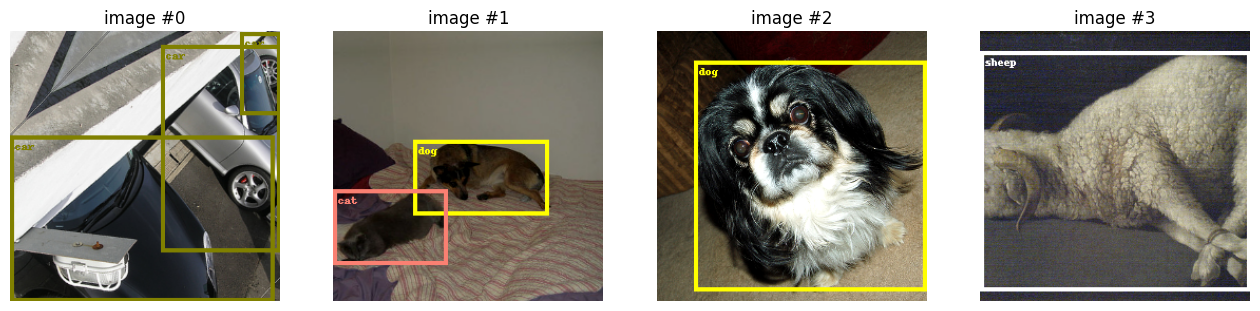

In [89]:
import matplotlib.pyplot as plt


def plot_images_list(images_list, labels_list=None, cols=4, cmap='gray', figsize=(16, 16)):
    sample_size = len(images_list)
    rows = sample_size // cols
    if sample_size % cols:
        rows += 1
    fig, m_axs = plt.subplots(rows, cols, figsize=figsize)
    for idx, (img, c_ax) in enumerate(zip(images_list, m_axs.flatten())):
        c_ax.imshow(img, cmap=cmap)
        label = f"image #{idx}"
        if labels_list is not None:
            label = labels_list[idx]
        c_ax.set_title(f'{label}')
        c_ax.axis('off')

        
def visualize_boxes(image, boxes=[], labels=[], scores=[], codec=None, width=4): 
    boxes = torch.from_numpy(np.array(boxes))
    image_cwh = torch.from_numpy(
        np.transpose(image, [2, 0, 1])
    )
    boxes_, labels_, colors_ = None, None, None
    vis = image_cwh.clone()

    if len(boxes):
        for obj_idx, (box, label) in enumerate(zip(boxes, labels)):
            label = codec.decode(label)
            color = codec.color(label)
            score = 1.
            if len(scores):
                score = scores[obj_idx]
                label += f": {'{:.2f}'.format(score)}"
            
            obj_width = max(1, int(width * score))

            vis = torchvision.utils.draw_bounding_boxes(
                        image=vis,
                        boxes=torch.stack([box]),
                        labels=[label],
                        width=obj_width,
                        colors=color,
                    )
    return np.transpose(vis.numpy(), [1, 2, 0])


def tensor2numpy(tensor):
    if tensor.requires_grad:
        tensor = tensor.detach()
    return tensor.numpy()


def visualize_batch(imgs_batch, boxes_batch=None, labels_batch=None, scores_batch=None, codec=None):
    images_bhwc = tensor2numpy(imgs_batch).astype(np.uint8)
    vis_images = []
    for image_idx, image in enumerate(images_bhwc):
        if boxes_batch and labels_batch:
            boxes = tensor2numpy(boxes_batch[image_idx])
            labels = tensor2numpy(labels_batch[image_idx])
            scores = []
            if scores_batch:
                scores = tensor2numpy(scores_batch[image_idx])
            
            image = visualize_boxes(image, boxes, labels, scores, codec=codec)
        vis_images.append(image)
    plot_images_list(vis_images)
    
    
visualize_batch(img, boxes, labels, codec=LabelsCodec())

## Full model

In [57]:
labels_codec = LabelsCodec()
print("Labels", len(labels_codec))
img_res = (512, 512)
print("Resolution", img_res)

preprocessor = FcosPreprocessor(img_res)
preprocessor_outputs, scales = preprocessor(img)
print("Preprocessor", preprocessor_outputs.shape)

core = FcosCore(backbone, len(labels_codec))
core_outputs = core(preprocessor_outputs)
print("Core")
for k, ((cls, cntr), r) in core_outputs.items():
    print(k, cls.shape, cntr.shape, r.shape)

feature_maps = {
    'P3': (64, 64),
    'P4': (32, 32),
    'P5': (16, 16),
    'P6': (8, 8),
    'P7': (4, 4),
}

Labels 20
Resolution (512, 512)
Preprocessor torch.Size([4, 3, 512, 512])
Core
P3 torch.Size([4, 20, 64, 64]) torch.Size([4, 1, 64, 64]) torch.Size([4, 4, 64, 64])
P4 torch.Size([4, 20, 32, 32]) torch.Size([4, 1, 32, 32]) torch.Size([4, 4, 32, 32])
P5 torch.Size([4, 20, 16, 16]) torch.Size([4, 1, 16, 16]) torch.Size([4, 4, 16, 16])
P6 torch.Size([4, 20, 8, 8]) torch.Size([4, 1, 8, 8]) torch.Size([4, 4, 8, 8])
P7 torch.Size([4, 20, 4, 4]) torch.Size([4, 1, 4, 4]) torch.Size([4, 4, 4, 4])


In [58]:
class FcosPostprocessor(nn.Module):
    def __init__(self, img_res, feature_maps, labels_codec):
        super().__init__()
        self._labels = labels_codec
        self._codecs = {
            k: DetectionsCodec(img_res, v, len(self._labels)) for k, v in feature_maps.items()
        }

    def _process_predictions(self, raw_predictions):
        predictions = {}
        for level, ((cls_outs, cntr_outs), regr_outs) in raw_predictions.items():
            codec = self._codecs[level]
            
            b, _, h, w = cls_outs.shape
            cls_outs = torch.reshape(cls_outs, (b, -1, h * w))
            cntr_outs = torch.reshape(cntr_outs, (b, -1, h * w))
            regr_outs = torch.reshape(regr_outs, (b, -1, h * w))
            plane_indices = torch.cat(
                [torch.reshape(torch.range(0, h * w - 1), (1, 1, h * w))] * b,
                axis=0,
            )
            batch_indices = torch.cat(
                [torch.full((1, 1, h * w), i) for i in range(b)],
                axis=0,
            )
            
            flat_outputs = torch.cat(
                [
                    batch_indices, cntr_outs, plane_indices, regr_outs, cls_outs
                ],
                axis=1,
            )
            flat_outputs = torch.permute(flat_outputs, (0, 2, 1)) # b, c, positions -> b, positions, c
            flat_outputs = torch.reshape(flat_outputs, (-1, flat_outputs.shape[-1]))
            
            predictions[level] = codec.decode(flat_outputs)
        
        return predictions

    def forward(self, raw_predictions, scales=None):
        """
        objects: [N x x {batch_idx, centerness, plane_idx, l, t, r, b, class_scores[...]}]
        return: [M x {batch_idx, xmin, ymin, xmax, ymax, scores[...]}]
        M <= N
        """
        detections_per_map = self._process_predictions(raw_predictions)
        all_detections = torch.cat(
            [detections for _, detections in detections_per_map.items()],
            axis=0
        )
        
        batches_cnt = 1 + torch.max(all_detections[:, 0]).int()
        batches = []
        for batch_idx in range(batches_cnt):
            mask = all_detections[:, 0] == batch_idx
            batch_detections = all_detections[mask]
            if scales:
                scale_y, scale_x = scales[batch_idx]
                batch_detections[:, 1] = batch_detections[:, 1] * scale_x
                batch_detections[:, 2] = batch_detections[:, 2] * scale_y
                batch_detections[:, 3] = batch_detections[:, 3] * scale_x
                batch_detections[:, 4] = batch_detections[:, 4] * scale_y
            
            batch_detections = torch.unsqueeze(batch_detections[:, 1:], 0)
            batches.append(batch_detections)

        batches = torch.cat(
            batches,
            axis = 0
        )
        
        return batches
        


proc = FcosPostprocessor(img_res, feature_maps, labels_codec)
res = proc(core_outputs)
print('Postprocessor:')
# res



Postprocessor:


/var/folders/3q/2zcvm1657mzdfv8n07vmkwr40000gn/T/ipykernel_1055/3009142506.py:19: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  [torch.reshape(torch.range(0, h * w - 1), (1, 1, h * w))] * b,


In [59]:
res.shape

torch.Size([4, 5456, 24])

In [72]:
labels_codec = LabelsCodec()
print("Labels", len(labels_codec))
img_res = (512, 512)
print("Resolution", img_res)


class FCOS(nn.Module):
    def __init__(self, backbone, labels_codec, res=(512, 512)):
        super().__init__()
        self._labels = labels_codec
        self._preprocessor = FcosPreprocessor(res)
        self._core = FcosCore(backbone, len(self._labels))
        feature_maps = {
            'P3': (64, 64),
            'P4': (32, 32),
            'P5': (16, 16),
            'P6': (8, 8),
            'P7': (4, 4),
        }
        self._postprocessor = FcosPostprocessor(res, feature_maps, self._labels)

    def forward(self, x):
        preprocessed_inputs, scales = self._preprocessor(x)
        core_outputs = self._core(preprocessed_inputs)
        outputs = self._postprocessor(core_outputs, scales)
        return outputs

    
full_model = FCOS(backbone, labels_codec, img_res)

Labels 20
Resolution (512, 512)


In [73]:
full_model

FCOS(
  (_preprocessor): FcosPreprocessor(
    (_normalize): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  )
  (_core): FcosCore(
    (_fext): FeatureExtractor(
      (_backbone): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256,

In [74]:
res = full_model(img)
res.shape

/var/folders/3q/2zcvm1657mzdfv8n07vmkwr40000gn/T/ipykernel_1055/3009142506.py:19: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  [torch.reshape(torch.range(0, h * w - 1), (1, 1, h * w))] * b,


torch.Size([4, 5456, 24])

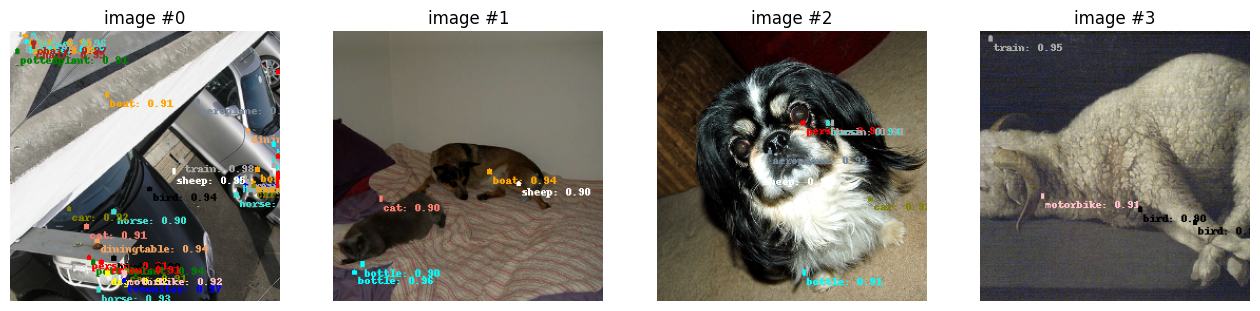

In [90]:
def draw_all_detections(imgs_batch, prediction, labels_codec, threshold=0.01):  
    boxes = []
    labels = []
    scores = []

    for img_pred in prediction:
        max_scores, max_indices = torch.max(img_pred[:, 4:], axis=1)
        mask = max_scores > threshold
        filtered_detections = img_pred[mask]
        
        img_boxes, img_labels, img_scores = [], [], []
        for detection_vector in filtered_detections:
            img_boxes.append(detection_vector[:4])
            label = torch.argmax(detection_vector[4:])
            img_labels.append(label)
            img_scores.append(detection_vector[4 + label])
        
        if len(img_boxes):
            img_boxes = torch.stack(img_boxes)
            img_labels = torch.tensor(img_labels)
            img_scores = torch.tensor(img_scores)
        else:
            img_boxes = torch.zeros((0, 4), dtype=torch.float)
            img_labels = torch.zeros((0, 1), dtype=torch.float)
            img_scores = torch.zeros((0, 1), dtype=torch.float)
        
        boxes.append(img_boxes)
        labels.append(img_labels)
        scores.append(img_scores)   

    visualize_batch(
        imgs_batch,
        boxes_batch=boxes,
        labels_batch=labels,
        scores_batch=scores,
        codec=labels_codec
    )

draw_all_detections(img, res, labels_codec, 0.9)

In [91]:
res.shape

torch.Size([4, 5456, 24])

In [93]:
labels, boxes

([tensor([11, 11, 11], dtype=torch.int32),
  tensor([17, 15], dtype=torch.int32),
  tensor([17], dtype=torch.int32),
  tensor([19], dtype=torch.int32)],
 [tensor([[218.0640,   1.1168, 256.0000,  79.4231],
          [143.5479,  13.0931, 256.0000, 209.3473],
          [  0.0000,  99.1072, 250.8246, 256.0000]]),
  tensor([[ 76.5414, 103.3040, 204.7911, 174.9603],
          [  0.0000, 150.4758, 108.7575, 221.4068]]),
  tensor([[ 35.6840,  28.8368, 255.5960, 246.5839]]),
  tensor([[  0.0000,  19.7973, 256.0000, 246.4427]])])

## Loss function

### Classification (Focal)

### Regression (IoU)

### Centerness (BCE)